# Clustering Algorithm

In this notebook we will take the cleaned botany data *data/labeled_clean_df.csv* and use an sklearn pipeline with parameter tuning to determine the best clustering algorithm parameters.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from plotting import plot_geographical_positions
from cluster_pipeline import create_pipeline, custom_cv_search

In [3]:
# Import the labeled, clean dataframe created in manual_cluster_labeling.ipynb

full_df = pd.read_csv('../data/labeled_clean_df.csv', index_col=0)

In [4]:
full_df

,index,collectingeventid,startdate,enddate,remarks,localityid,minelevation,maxelevation,elevationaccuracy,latitude1,...,localityname,namedplace,geographyid,centroidlat,centroidlon,commonname,fullname,name,spatial_flag,cluster
97080,343455,441847,1808-04-20,NaN,NaN,442466.0,NaN,NaN,NaN,26.495565,...,"habitat in montosis Camrupa [Kamrup?], Bhatgon...",NaN,33649.0,NaN,NaN,NaN,"Kishanganj, State of Bihar, India",Kishanganj,1,NaN
111826,420427,536221,1808-04-20,NaN,NaN,536942.0,NaN,NaN,NaN,26.495565,...,Bhatgong [=Bhatgaon?],NaN,33649.0,NaN,NaN,NaN,"Kishanganj, State of Bihar, India",Kishanganj,1,NaN
104169,379937,487639,1809-04-01,NaN,NaN,488822.0,NaN,NaN,NaN,26.520000,...,"habitat in montosis Camrupa [Kamrup?], Jolpigo...",NaN,33612.0,NaN,NaN,NaN,"Jalpaiguri, State of West Bengal, India",Jalpaiguri,1,NaN
111825,420426,536220,1809-04-01,NaN,NaN,536941.0,NaN,NaN,NaN,26.520000,...,Jolpigory [=Jalpaiguri],NaN,33612.0,NaN,NaN,NaN,"Jalpaiguri, State of West Bengal, India",Jalpaiguri,1,NaN
114498,431463,550870,1809-04-01,NaN,NaN,536941.0,NaN,NaN,NaN,26.520000,...,Jolpigory [=Jalpaiguri],NaN,33612.0,NaN,NaN,NaN,"Jalpaiguri, State of West Bengal, India",Jalpaiguri,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233731,813130,996140,2024-09-30,NaN,"Open, sunny. At top of bank of creek and road ...",931454.0,15.0,NaN,NaN,47.053971,...,"unincorporated county, west side of Hartman Rd...",NaN,25774.0,46.92,-100.0,NaN,"Thurston County, Washington, United States",Thurston County,1,NaN
233732,813131,996141,2024-10-09,NaN,"Open, sunny, lightly vegetated cobble/gravel b...",931455.0,620.0,NaN,NaN,46.857071,...,"unincorporated county, Mashel River, 0.2 miles...",NaN,20673.0,47.03,-100.0,NaN,"Pierce County, Washington, United States",Pierce County,1,NaN
233733,813132,996142,2024-10-14,NaN,"Very steep, north- to northwest-facing, open, ...",931456.0,100.0,NaN,NaN,47.031033,...,"Olympia, southeast side of Lakeridge Dr SW, 70...",NaN,25774.0,46.92,-100.0,NaN,"Thurston County, Washington, United States",Thurston County,1,NaN
233735,813134,996144,2024-10-17,NaN,"Flat, ruderal, weedy area and adjacent man-mad...",931458.0,205.0,NaN,NaN,46.973870,...,"unincorporated county, northwestern edge of a ...",NaN,25774.0,46.92,-100.0,NaN,"Thurston County, Washington, United States",Thurston County,1,NaN


In [5]:
full_df.columns

Index(['index', 'collectingeventid', 'startdate', 'enddate', 'remarks',
       'localityid', 'minelevation', 'maxelevation', 'elevationaccuracy',
       'latitude1', 'longitude1', 'localityname', 'namedplace', 'geographyid',
       'centroidlat', 'centroidlon', 'commonname', 'fullname', 'name',
       'spatial_flag', 'cluster'],
      dtype='object')

## 1. Simple Clustering: Spatiotemporal

First, we will build a pipeline that will transform and perform dbscan clustering on our data. We will then compare the results of this clustering against the 11 manually labeled clusters.

In [6]:
# Subset the full_df to only the columns we care about. For readability
df = full_df.reset_index(drop=True)[['collectingeventid', 'startdate', 'remarks', 'latitude1', 'longitude1', 'localityname', 'cluster']]

df

,collectingeventid,startdate,remarks,latitude1,longitude1,localityname,cluster
0,441847,1808-04-20,NaN,26.495565,88.114457,"habitat in montosis Camrupa [Kamrup?], Bhatgon...",NaN
1,536221,1808-04-20,NaN,26.495565,88.114457,Bhatgong [=Bhatgaon?],NaN
2,487639,1809-04-01,NaN,26.520000,88.730000,"habitat in montosis Camrupa [Kamrup?], Jolpigo...",NaN
3,536220,1809-04-01,NaN,26.520000,88.730000,Jolpigory [=Jalpaiguri],NaN
4,550870,1809-04-01,NaN,26.520000,88.730000,Jolpigory [=Jalpaiguri],NaN
...,...,...,...,...,...,...,...
239355,996140,2024-09-30,"Open, sunny. At top of bank of creek and road ...",47.053971,-122.719350,"unincorporated county, west side of Hartman Rd...",NaN
239356,996141,2024-10-09,"Open, sunny, lightly vegetated cobble/gravel b...",46.857071,-122.306897,"unincorporated county, Mashel River, 0.2 miles...",NaN
239357,996142,2024-10-14,"Very steep, north- to northwest-facing, open, ...",47.031033,-122.912741,"Olympia, southeast side of Lakeridge Dr SW, 70...",NaN
239358,996144,2024-10-17,"Flat, ruderal, weedy area and adjacent man-mad...",46.973870,-122.882312,"unincorporated county, northwestern edge of a ...",NaN


### a. CV Search Parameter Tuning

In [8]:
# Creating this pipeline here so its parameters can be adjusted and tuned in custom_cv_search below
pipeline = create_pipeline(e_dist=0.01, e_days=30)

# Creating a parameter grid to run across the cv search. NOTE: This could be extended, made more granular
param_grid = {
    'spatial_dbscan__e_dist': [.1, 1, 5, 10, 15, 20],
    'temporal_dbscan__e_days': [3, 5, 7, 9, 10]
}

best_params, best_score, scores = custom_cv_search(df, pipeline, param_grid)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("All Scores:", scores)

Best Parameters: {'spatial_dbscan__e_dist': 5, 'temporal_dbscan__e_days': 7}
Best Score: 0.294776395337642
All Scores: [0.5600178515838617, 0.5600178515838617, 0.5600178515838617, 0.5600178515838617, 0.5600178515838617, 0.45819170603130105, 0.45819170603130105, 0.45819170603130105, 0.45819170603130105, 0.45819170603130105, 0.3033478239090705, 0.3033478239090705, 0.294776395337642, 2.5852525858138327, 2.5852525858138327, 29.55104474771983, 35.71354474771982, 70.80679047997499, 70.80679047997499, 91.02551689506933, 29.588466131367625, 35.86346613136763, 80.67331114484472, 93.72979137844759, 93.72979137844759, 29.588618686668923, 35.86361868666893, 80.67346370014602, 93.72994393374888, 93.72994393374888]


In [10]:
best_params

{'spatial_dbscan__e_dist': 5, 'temporal_dbscan__e_days': 7}

### b. Fit Pipeline with best params

In [16]:
pipeline = create_pipeline(e_dist=best_params['spatial_dbscan__e_dist'], e_days=best_params['temporal_dbscan__e_days'])

processed_df = pipeline.transform(df)

In [17]:
pipeline

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('spatial_dbscan', SpatialDBSCAN(e_dist=5)),
                ('temporal_dbscan', TemporalDBSCAN(e_days=7)),
                ('combine_clusters', CombineClusters())])

In [18]:
processed_df.cluster

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
239355   NaN
239356   NaN
239357   NaN
239358   NaN
239359   NaN
Name: cluster, Length: 239154, dtype: float64

In [19]:
for i in np.arange(0, 11):
    df1 = processed_df[processed_df.cluster == i]
    stc_id = df1.spatiotemporal_cluster_id.sample(1).values[0]
    print('clust', i, '- manual size: ', len(df1), ', algorithm size: ', len(processed_df[processed_df.spatiotemporal_cluster_id == stc_id]))

clust 0 - manual size:  265 , algorithm size:  267
clust 1 - manual size:  8 , algorithm size:  8
clust 2 - manual size:  1 , algorithm size:  1
clust 3 - manual size:  2622 , algorithm size:  16
clust 4 - manual size:  3846 , algorithm size:  5
clust 5 - manual size:  59 , algorithm size:  59
clust 6 - manual size:  70 , algorithm size:  47
clust 7 - manual size:  1 , algorithm size:  1
clust 8 - manual size:  7 , algorithm size:  7
clust 9 - manual size:  21 , algorithm size:  8
clust 10 - manual size:  1072 , algorithm size:  1034


np.int64(22304)

In [20]:
processed_df.to_csv('../data/processed_df.csv')

### c. Visual Inspection

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


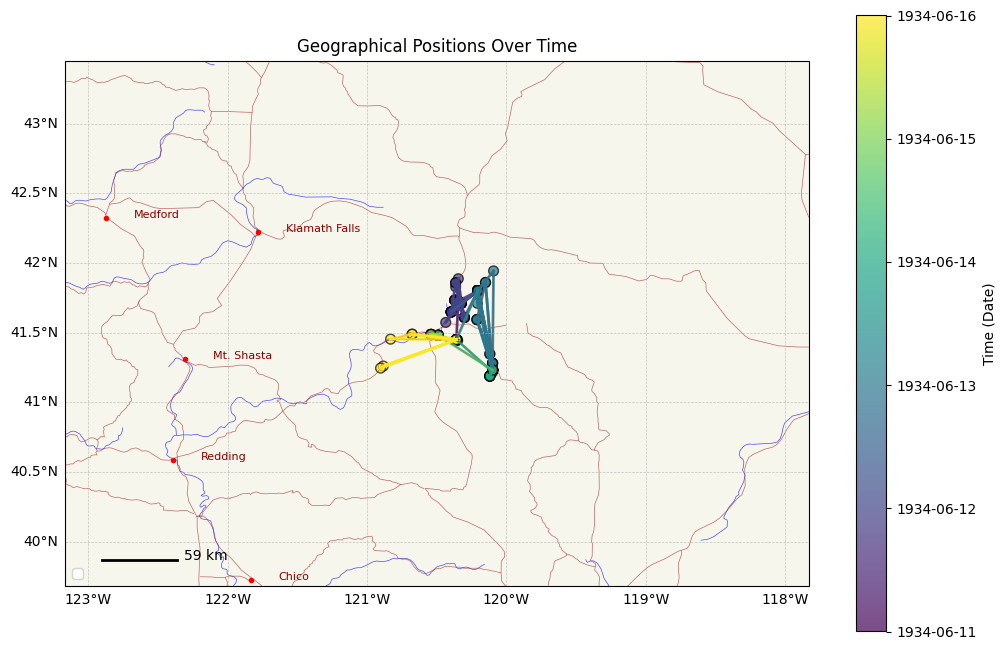

In [21]:
i = 0

stc_id = processed_df[processed_df.cluster == i].iloc[0].spatiotemporal_cluster_id

plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == stc_id], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, )

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


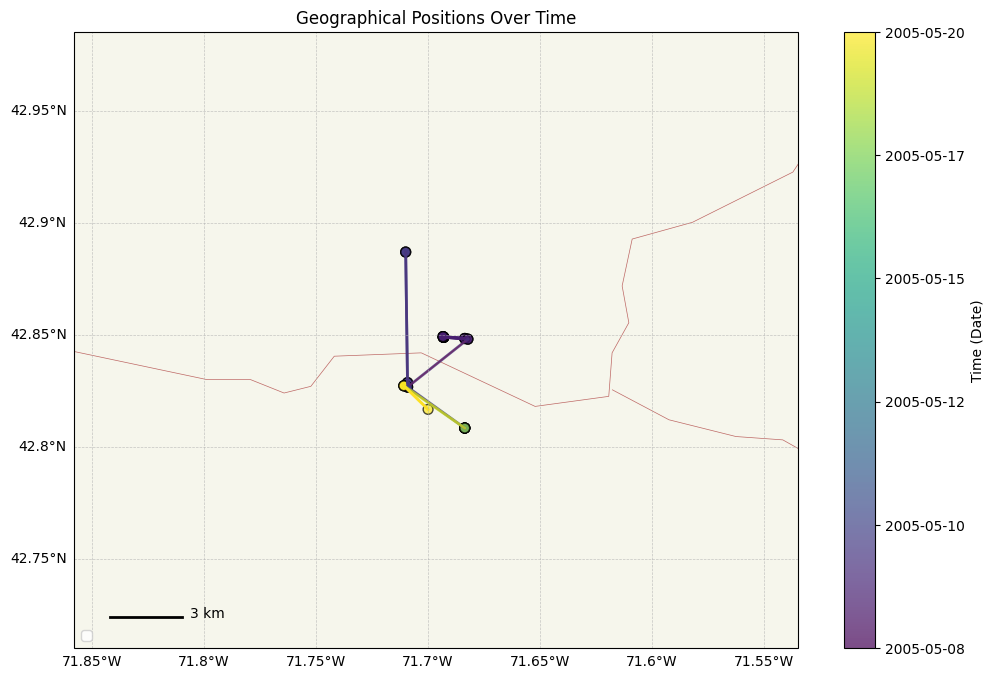

In [22]:
i = 6

stc_id = processed_df[processed_df.cluster == i].iloc[0].spatiotemporal_cluster_id

plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == stc_id], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.8, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, )

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


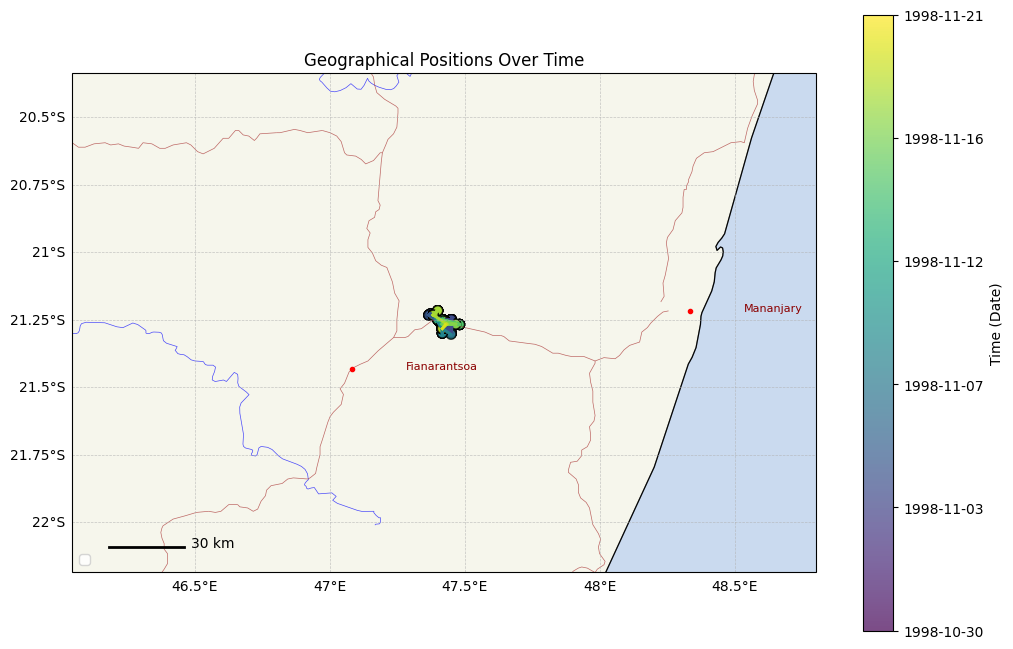

In [23]:
i = 10

stc_id = processed_df[processed_df.cluster == i].iloc[0].spatiotemporal_cluster_id

plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == stc_id], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.1, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, )

In [24]:
biggest_clusters = processed_df.groupby('spatiotemporal_cluster_id').size().sort_values(ascending=False).head(20)
biggest_clusters

spatiotemporal_cluster_id
26346    2981
27063    2355
25830    2291
25423    1880
17598    1821
26191    1685
25106    1609
26134    1581
27062    1486
26795    1456
24558    1450
20812    1383
22304    1034
23093    1010
22823     748
30026     693
34469     636
26797     633
25211     620
27870     596
dtype: int64

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


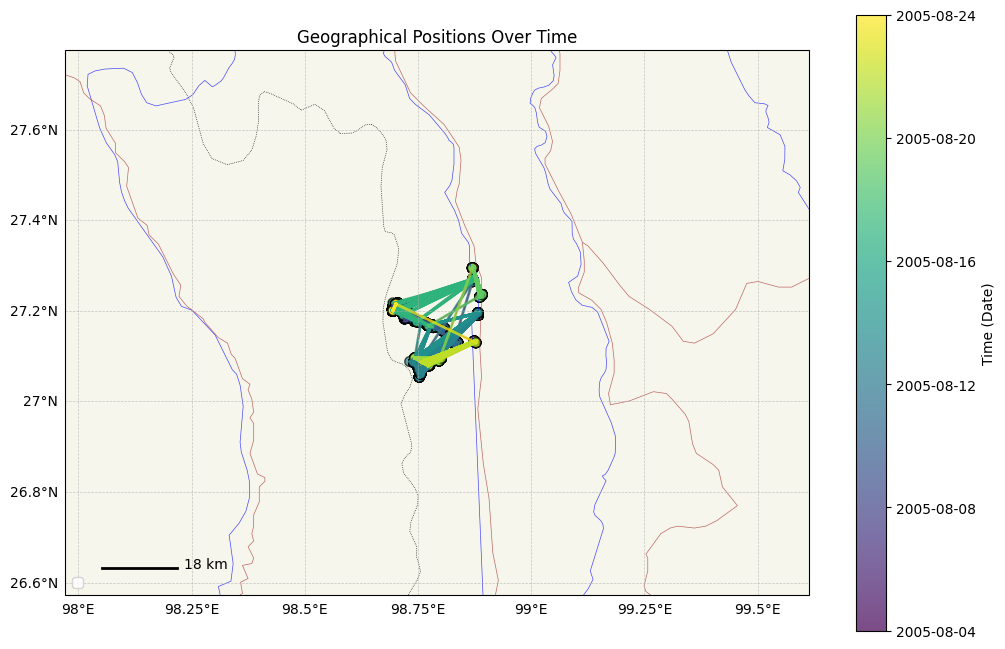

In [25]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[0]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)


/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


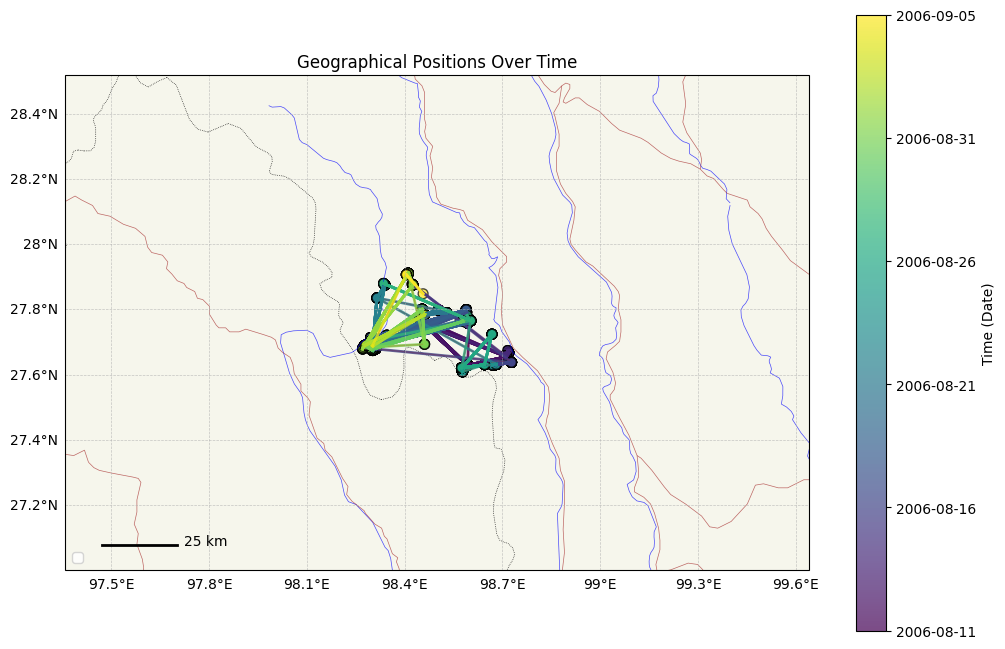

In [26]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[1]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)


/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


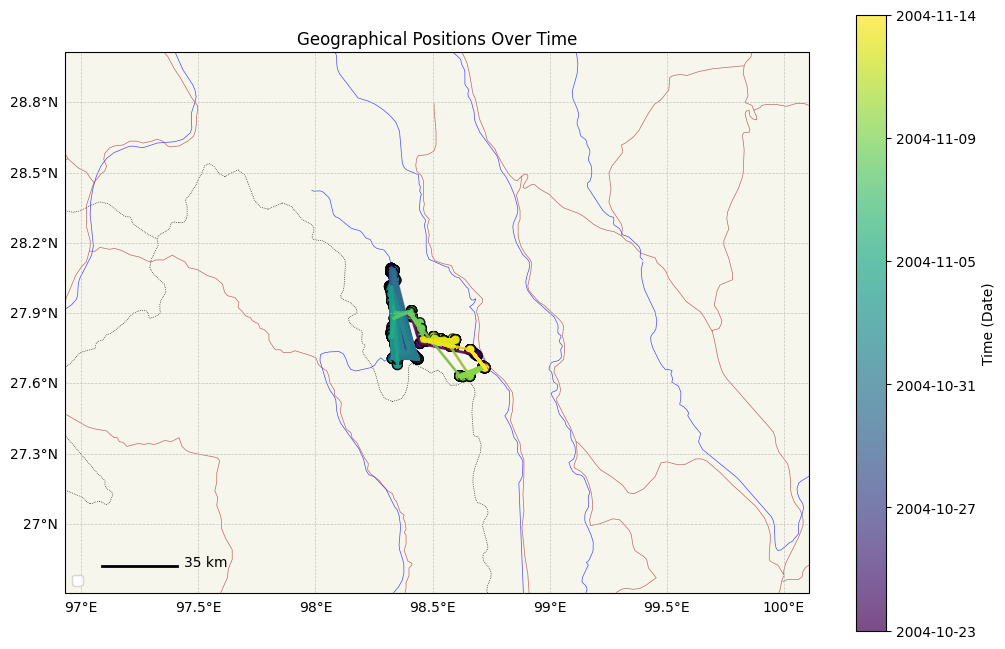

In [27]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[2]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)


/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


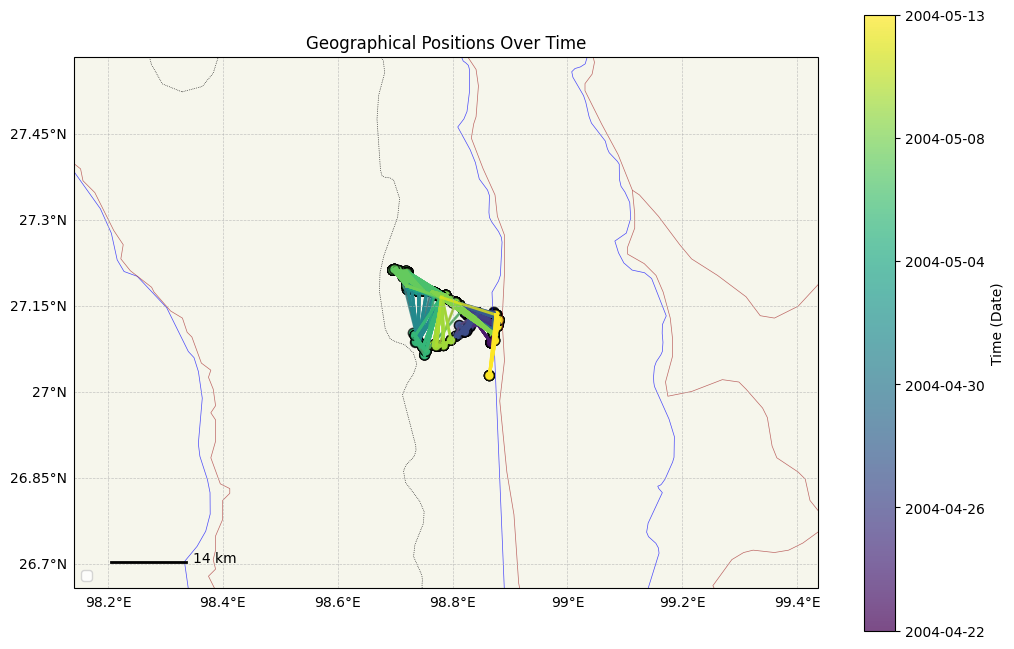

In [28]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[3]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


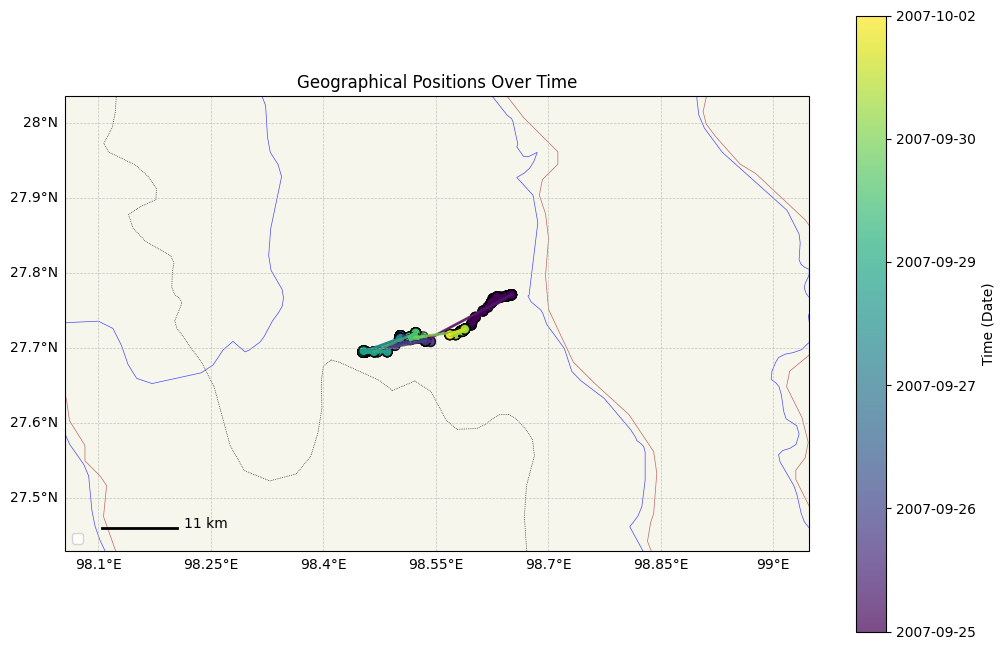

In [29]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[19]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


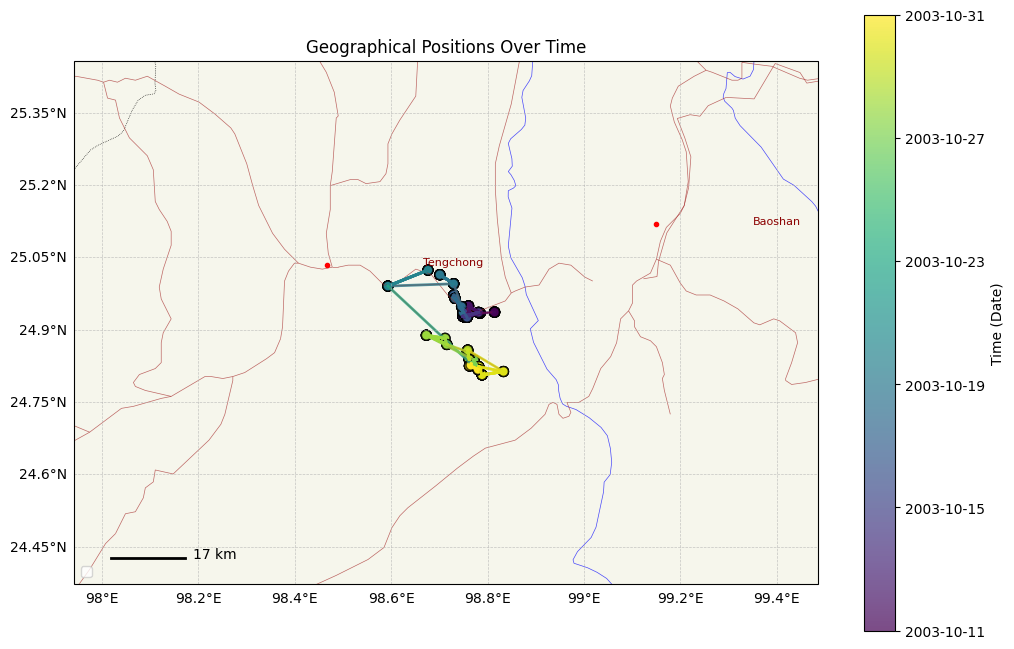

In [30]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[18]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)

This one is questionable! I feel like this likely is a number of clusters since its over a period of 2 months... 